#### 세팅

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

In [11]:
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence

from pygam import LinearGAM, s, l
from pygam.datasets import wage


import seaborn as sns
import matplotlib.pyplot as plt

from dmba import stepwise_selection
from dmba import AIC_score

In [12]:
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

In [13]:
LUNG_CSV = DATA / 'LungDisease.csv'
HOUSE_CSV = DATA / 'house_sales.csv'

### 단순선형회귀
- 응답변수(반응변수, 종속변수,Y, response variable) : 예측하고자 하는 변수
- 독립변수(예측변수, X, 피처, independent variable) : 응답치를 예측하기 위해 사용되는 변수
- 레코드(행,사건,예시,record) : 한 특정 경우에 대한 입력과 출력을 담고 있는 벡터
- 절편(intercept) : 회귀직선의 절편, 즉, X=0일 때 예측값
- 회귀계수(기울기,모수 추정값, 가중치,regression coefficient) : 회귀직선의 기울기
- 적합값(예측값, fitted value) : 회귀선으로부터 얻은 추정치
- 잔차 (오차, residual) : 관측값과 적합값의 차이
- 최소제곱(보통최소제곱,OLS,least square) : 잔차의 제곱합을 최소화하여 회귀를 피팅하는 방법

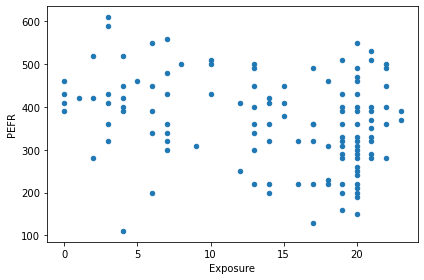

In [26]:
lung = pd.read_csv(LUNG_CSV)

lung.plot.scatter(x='Exposure', y='PEFR')

plt.tight_layout()
plt.show()

In [17]:
predictors = ['Exposure']
outcome = 'PEFR'

model = LinearRegression()
model.fit(lung[predictors], lung[outcome])

print(f'Intercept: {model.intercept_:.3f}')
print(f'Coefficient Exposure: {model.coef_[0]:.3f}')

Intercept: 424.583
Coefficient Exposure: -4.185


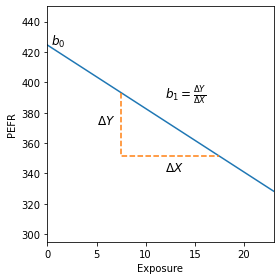

In [27]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_xlim(0, 23)
ax.set_ylim(295, 450)
ax.set_xlabel('Exposure')
ax.set_ylabel('PEFR')
ax.plot((0, 23), model.predict(pd.DataFrame({'Exposure': [0, 23]})))
ax.text(0.4, model.intercept_, r'$b_0$', size='larger')

x = pd.DataFrame({'Exposure': [7.5,17.5]})
y = model.predict(x)
ax.plot((7.5, 7.5, 17.5), (y[0], y[1], y[1]), '--')
ax.text(5, np.mean(y), r'$\Delta Y$', size='larger')
ax.text(12, y[1] - 10, r'$\Delta X$', size='larger')
ax.text(12, 390, r'$b_1 = \frac{\Delta Y}{\Delta X}$', size='larger')

plt.tight_layout()
plt.show()

### 적합값과 잔차
- 적합값(예측값)
- 잔차(예측 오차)

In [28]:
fitted = model.predict(lung[predictors])
residuals = lung[outcome] - fitted

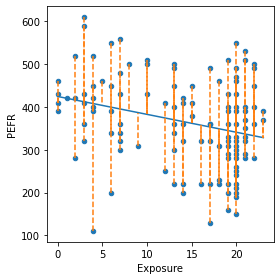

In [29]:
# 회귀선에 대한 잔차
ax = lung.plot.scatter(x='Exposure', y='PEFR', figsize=(4, 4))
ax.plot(lung.Exposure, fitted)
for x, yactual, yfitted in zip(lung.Exposure, lung.PEFR, fitted): 
    ax.plot((x, x), (yactual, yfitted), '--', color='C1')

plt.tight_layout()
plt.show()

### 최소제곱
- 실무에서 회귀선은 잔차들을 제곱한 값들의 합인 잔차제곱합(RSS)을 최소화하는 선이다.
- 잔차제곱합을 최소화하는 방법을 최소제곱회귀(또는 보통최소제곱OLS)회귀라고 한다.

### 예측 대 설명
- 회귀방정식은 응답변수Y와 예측변수X 간의 관계를 선형함수로 모델링한다.
- 회귀모형은 적합값과 잔차, 즉 반응에 대한 예측과 그 예측 오차를 산출한다.
- 회귀모형은 일반적으로 최소제곱법을 이용해 피팅한다.
- 회귀는 예측과 설명 모두에 사용된다.

### 다중선형회귀
- 제곱근평균제곱오차(RMSE) : 회귀 시 평균제곱오차의 제곱근, 회귀모형을 평가하는 데 가장 널리 사용되는 측정 지표다.
- 잔차 표준오차(RSE) : 평균제곱오차와 동일하지만 자유도에 따라 보정된 값
- R제곱(결정계수) : 0에서 1까지 모델에 의해 설명된 분산의 비율\
- 분산 : 변량이 퍼져있는 정도
- t통계량 : 계수의 표준오차로 나눈 예측변수의 계수. 모델에서 변수의 중요도를 비교하는 기준이 된다.
- 가중회귀 : 다른 가중치를 가진 레코드들을 회귀하는 방법

In [30]:
subset = ['AdjSalePrice', 'SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
          'Bedrooms', 'BldgGrade']

house = pd.read_csv(HOUSE_CSV, sep='\t')
print(house[subset].head())

   AdjSalePrice  SqFtTotLiving  SqFtLot  Bathrooms  Bedrooms  BldgGrade
1      300805.0           2400     9373       3.00         6          7
2     1076162.0           3764    20156       3.75         4         10
3      761805.0           2060    26036       1.75         4          8
4      442065.0           3200     8618       3.75         5          7
5      297065.0           1720     8620       1.75         4          7


In [31]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_lm = LinearRegression()
house_lm.fit(house[predictors], house[outcome])

print(f'Intercept: {house_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(predictors, house_lm.coef_):
    print(f' {name}: {coef}')

Intercept: -521871.368
Coefficients:
 SqFtTotLiving: 228.8306036024083
 SqFtLot: -0.0604668206530512
 Bathrooms: -19442.840398320997
 Bedrooms: -47769.955185214465
 BldgGrade: 106106.96307898074


### 모형 평가
- 제곱근평균제곱오차(RMSE) :  예측된 값들의 평균제곱오차의 제곱근

In [32]:
fitted = house_lm.predict(house[predictors])
RMSE = np.sqrt(mean_squared_error(house[outcome], fitted))
r2 = r2_score(house[outcome], fitted)
print(f'RMSE: {RMSE:.0f}')
print(f'r2: {r2:.4f}')

RMSE: 261220
r2: 0.5406


In [33]:
# t통계량이 높을수록(p값이 낮을 수록) 예측변수는 더욱 유의미 하다.
model = sm.OLS(house[outcome], house[predictors].assign(const=1))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     5338.
Date:                Sun, 29 Oct 2023   Prob (F-statistic):               0.00
Time:                        18:46:45   Log-Likelihood:            -3.1517e+05
No. Observations:               22687   AIC:                         6.304e+05
Df Residuals:                   22681   BIC:                         6.304e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
SqFtTotLiving   228.8306      3.899     58.694

### 교차타당성 검사
- 교차타당성검사(cross-validation) : 홀드아웃 샘플 아이디어를 여러 개의 연속된 홀드아웃 샘플로 확장한 것.
- k다중 교차타당성검사 가 기본적이다.
- 폴드(fold) : 훈련을 위한 홀드아웃 샘플로 데이터를 나누는 것

### 모형 선택 및 단계적 회귀
- 더 많은 변수를 추가한다고 해서 꼭 더 좋은 모델을 얻는 것이 아니다.
- 모델 선택을 위한 지침으로 오컴의 면도날이라는 원리를 사용한다. 
- 모든 것이 동일한 조건에서는, 복잡한 모델보다는 단순한 모델을 우선 사용해야 한다는 원리.
- 변수를 추가할 수록 학습 데이터에 대해 항상 RMSE는 감소하고, R^2는 증가한다. 따라서 추가하는 변수들은 모델 선택에 별로 도움 되지 않는다.

In [34]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'NbrLivingUnits',
              'SqFtFinBasement', 'YrBuilt', 'YrRenovated', 
              'NewConstruction']

X = pd.get_dummies(house[predictors], drop_first=True, dtype=int)
X['NewConstruction'] = [1 if nc else 0 for nc in X['NewConstruction']]

house_full = sm.OLS(house[outcome], X.assign(const=1))
results = house_full.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     2771.
Date:                Sun, 29 Oct 2023   Prob (F-statistic):               0.00
Time:                        19:14:14   Log-Likelihood:            -3.1375e+05
No. Observations:               22687   AIC:                         6.275e+05
Df Residuals:                   22674   BIC:                         6.276e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
SqFtTotLiving       

In [35]:
# AIC : 모델에 항을 추가할수록 불이익을 주는 측정 기준
# 1. 주어진 변수 집합에 대해 적합 모델을 변환하는 함수를 정의한다.
# 2. 주어진 모델과 변수 세트에 대한 점수를 반환하는 함수를 정의한다.
y = house[outcome]

def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(X[variables], y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(y, [y.mean()] * len(y), model, df=1)
    return AIC_score(y, model.predict(X[variables]), model)

best_model, best_variables = stepwise_selection(X.columns, train_model, score_model, 
                                                verbose=True)

print()
print(f'Intercept: {best_model.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(best_variables, best_model.coef_):
    print(f' {name}: {coef}')

Variables: SqFtTotLiving, SqFtLot, Bathrooms, Bedrooms, BldgGrade, NbrLivingUnits, SqFtFinBasement, YrBuilt, YrRenovated, NewConstruction, PropertyType_Single Family, PropertyType_Townhouse
Start: score=647988.32, constant
Step: score=633013.35, add SqFtTotLiving
Step: score=630793.74, add BldgGrade
Step: score=628230.29, add YrBuilt
Step: score=627784.16, add Bedrooms
Step: score=627602.21, add Bathrooms
Step: score=627525.65, add PropertyType_Townhouse
Step: score=627525.08, add SqFtFinBasement
Step: score=627524.98, add PropertyType_Single Family
Step: score=627524.98, unchanged None

Intercept: 6178645.017
Coefficients:
 SqFtTotLiving: 199.27755304201781
 BldgGrade: 137159.56022619802
 YrBuilt: -3565.424939249281
 Bedrooms: -51947.38367361341
 Bathrooms: 42396.16452771811
 PropertyType_Townhouse: 84479.16203300335
 SqFtFinBasement: 7.046974967583083
 PropertyType_Single Family: 22912.055187017646


### 가중회귀
- 서로 다른 관측치를 다른 정밀도로 측정했을 때, 역분산 가중치를 얻을 수 있다. 분산이 높을 수록 가중치가 낮다.
- 가중치 변수가 집계된 데이터의 각 행이 나타내는 원본 관측치의 수를 인코딩하도록, 행이 여러 경우를 의미하는 데이터를 분석할 수 있다.

- 다중선형회귀모형은 한 응단변수Y와 여러개의 예측변수 간의 관계를 나타낸다.
- 모델을 평가하는 가장 중요한 지표는 제곱근평균제곱오차(RMSE)와 R제곱(R^2)이다.
- 계수들의 표준오차는 모델에 대한 변수 기여도의 신뢰도를 측정하는데 사용된다.
- 단계적 회귀는 모델을 만드는데 필요한 변수들을 자동으로 결정하는 방법이다.
- 가중회귀는 방정식을 피팅할 때 레코드별로 가중치를 주기 위해 사용한다.

In [36]:
house['Year'] = [int(date.split('-')[0]) for date in house.DocumentDate]
house['Year'] = house.DocumentDate.apply(lambda d: int(d.split('-')[0]))
house['Weight'] = house.Year - 2005

In [37]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_wt = LinearRegression()
house_wt.fit(house[predictors], house[outcome], sample_weight=house.Weight)

pd.concat([
    pd.DataFrame({
        'predictor': predictors,
        'house_lm': house_lm.coef_,
        'house_wt': house_wt.coef_,    
    }),
    pd.DataFrame({
        'predictor': ['intercept'],
        'house_lm': house_lm.intercept_,
        'house_wt': house_wt.intercept_,    
    })
])

,predictor,house_lm,house_wt
0,SqFtTotLiving,228.830604,245.024089
1,SqFtLot,-0.060467,-0.292415
2,Bathrooms,-19442.840398,-26085.970109
3,Bedrooms,-47769.955185,-53608.876436
4,BldgGrade,106106.963079,115242.434726
0,intercept,-521871.368188,-584189.329446


In [38]:
residuals = pd.DataFrame({
    'abs_residual_lm': np.abs(house_lm.predict(house[predictors]) - house[outcome]),
    'abs_residual_wt': np.abs(house_wt.predict(house[predictors]) - house[outcome]),
    'Year': house['Year'],
})
print(residuals.head())
# axes = residuals.boxplot(['abs_residual_lm', 'abs_residual_wt'], by='Year', figsize=(10, 4))
# axes[0].set_ylim(0, 300000)

pd.DataFrame(([year, np.mean(group['abs_residual_lm']), np.mean(group['abs_residual_wt'])] 
              for year, group in residuals.groupby('Year')),
             columns=['Year', 'mean abs_residual_lm', 'mean abs_residual_wt'])
# for year, group in residuals.groupby('Year'):
#     print(year, np.mean(group['abs_residual_lm']), np.mean(group['abs_residual_wt']))

   abs_residual_lm  abs_residual_wt  Year
1    123750.814194    107108.553965  2014
2     59145.413089     96191.882094  2006
3    190108.725716    187004.492880  2007
4    198788.774412    196132.996857  2008
5     91774.996129     84277.577512  2013


,Year,mean abs_residual_lm,mean abs_residual_wt
0,2006,140540.303585,146557.454636
1,2007,147747.577959,152848.523235
2,2008,142086.905943,146360.411668
3,2009,147016.720883,151182.924825
4,2010,163267.674885,166364.476152
5,2011,169937.385744,172950.876028
6,2012,169506.670053,171874.424266
7,2013,203659.777510,206242.199403
8,2014,184452.840665,186668.573750
9,2015,172323.435147,169842.742053


### 회귀를 이용한 예측
- 예측구간 : 개별 예측값 주위의 불확실한 구간
- 외삽법(extrapolation) : 모델링에 사용된 데이터 범위를 벗어난 부분까지 모델을 확장하는것
- 회귀모형을 데이터 범위를 초과하면서까지 외삽하는데 사용해서는 안된다.
- 회귀모형은 충분한 데이터 값이 있는 예측변수에 대해서만 유효하다.
- 개별 데이터 값의 오차는 회귀방정식이 무엇인지 정확히 알았다 하더라도 주어진 예측변숫값에 대한 실제 결괏값은 달라질 수 있다.
주요개념
- 데이터 범위를 벗어나는 외삽은 오류를 유발할 수 있다.
- 신뢰구간은 회귀계수 주변의 불확실성을 정량화한다.
- 예측구간은 개별 예측값의 불확실성을 정량화한다.
- 예측 및 신뢰 구간 생성을 위한 수식 대신 부트스트랩을 사용할 수 있다. 해석과 개념은 같다.

### 회귀에서의 요인변수
- 요인변수(범주변수) : 개수가 제한된 이산값을 취한다.
- 가변수(dummy variable) : 회귀나 다른 모델에서 요인 데이터를 사용하기 위해 0과 1의 이진변수로 부호화한 변수
- 기준 부호화(처리부호화, reference coding) :  통계학자들이 많이 사용하는 부호화 형태, 여기서 한 요인을 기준으로하고 다른 요인들이 이 기준에 따라 비교할 수 있도록 한다.
- 원핫 인코딩 : 머신러닝 분야에서 많이 사용되는 부호화. 모든 요인 수준이 계속 유지된다. 어떤 머신러닝 알고리즘에서는 유용한 반면, 다중선형회귀에는 적합하지 않다.
- 편차 부호화(총합대비,deviation coding): 기준 수준과는 반대로 전체 평균에 대해 각 수준을 비교하는 부호화 방법

In [39]:
print(house.PropertyType.head())

1        Multiplex
2    Single Family
3    Single Family
4    Single Family
5    Single Family
Name: PropertyType, dtype: object


In [40]:
print(pd.get_dummies(house['PropertyType']).head(6))

   Multiplex  Single Family  Townhouse
1          1              0          0
2          0              1          0
3          0              1          0
4          0              1          0
5          0              1          0
6          0              0          1


In [41]:
print(pd.get_dummies(house['PropertyType'], drop_first=True).head(6))

   Single Family  Townhouse
1              0          0
2              1          0
3              1          0
4              1          0
5              1          0
6              0          1


In [42]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType']

X = pd.get_dummies(house[predictors], drop_first=True)

house_lm_factor = LinearRegression()
house_lm_factor.fit(X, house[outcome])

print(f'Intercept: {house_lm_factor.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(X.columns, house_lm_factor.coef_):
    print(f' {name}: {coef}')

Intercept: -446841.366
Coefficients:
 SqFtTotLiving: 223.37362892503862
 SqFtLot: -0.0703679813681326
 Bathrooms: -15979.013473414965
 Bedrooms: -50889.73218483036
 BldgGrade: 109416.30516146174
 PropertyType_Single Family: -84678.21629549288
 PropertyType_Townhouse: -115121.97921609206


### 다수의 수준을 갖는 요인변수들

In [43]:
print(pd.DataFrame(house['ZipCode'].value_counts()).transpose())

         98038  98103  98042  98115  98117  98052  98034  98033  98059  98074  \
ZipCode    788    671    641    620    619    614    575    517    513    502   

         ...  98051  98024  98354  98050  98288  98057  98224  98113  98043  \
ZipCode  ...     32     31      9      7      4      4      3      1      1   

         98068  
ZipCode      1  

[1 rows x 80 columns]


In [44]:
# 대안은 매매 가격과 같은 다른 변수에 따라 우편번호를 그룹으로 묶는것이다. 
# 아니면 초기 모델의 잔차를 사용하여 우편번호 그룹을 만드는 방법도 좋다.
house = pd.read_csv(HOUSE_CSV, sep='\t')

predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_lm = LinearRegression()
house_lm.fit(house[predictors], house[outcome])


zip_groups = pd.DataFrame([
    *pd.DataFrame({
        'ZipCode': house['ZipCode'],
        'residual' : house[outcome] - house_lm.predict(house[predictors]),
    })
    .groupby(['ZipCode'])
    .apply(lambda x: {
        'ZipCode': x.iloc[0,0],
        'count': len(x),
        'median_residual': x.residual.median()
    })
]).sort_values('median_residual')
zip_groups['cum_count'] = np.cumsum(zip_groups['count'])
zip_groups['ZipGroup'] = pd.qcut(zip_groups['cum_count'], 5, labels=False, retbins=False)
zip_groups.head()
print(zip_groups.ZipGroup.value_counts().sort_index())

0    16
1    16
2    16
3    16
4    16
Name: ZipGroup, dtype: int64


In [45]:
to_join = zip_groups[['ZipCode', 'ZipGroup']].set_index('ZipCode')
house = house.join(to_join, on='ZipCode')
house['ZipGroup'] = house['ZipGroup'].astype('category')

### 순서가 있는 요인변수
- 순서 범주형 변수 : 일반적으로 숫자 값으로 변환하여 그대로 사용할 수 있다.
- 요인변수는 회귀를 위해 수치형 변수로 변환해야 한다.
- 요인변수를 P개의 개별 값으로 인코딩하기 위한 가장 흔한 방법은 P-1개의 가변수를 만들어 사용하는 것이다.
- 다수의 수준을 갖는 요인변수의 경우, 더 적은 수의 수준을 갖는 변수가 되도록 수준들을 통합해야한다.
- 순서를 갖는 요인변수의 경우, 수치형 변수로 변환하여 사용할 수 있다.

### 회귀방정식 해석
- 변수 간 상관(correlated variables) : 변수들이 같은 방향으로 움직이려는 경향을 가짐. 예측변수끼리 서로 높은 상관성을 가질때는 개별 계수를 해석하는 것이 어렵다.
- 다중공선성(공선성, multicolinearity) : 예측변수들이 완벽하거나 거의 완벽에 가까운 상관성을 갖는다고 할때, 회귀는 불안정하며 계산이 불가능하다.
- 교란변수(confuounding variable) : 중요한 예측변수이지만 회귀방정식에 누락되어 결과를 잘못되게 이끄는 변수
- 주효과(main effect) : 다른변수들과 독립된, 하나의 예측변수와 결과변수 사이의 관계
- 상호작용(interaction) : 둘 이상의 예측변수와 응답변수 사이의 상호 의존적인 관꼐

### 예측변수 간 상관

In [46]:
# Bedrooms의 계수가 음수인걸 볼 수 있다.
# 즉 침실 개수를 늘릴 수록 그 가치가 감소한다는 것을 의미한다.
print(f'Intercept: {best_model.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(best_variables, best_model.coef_):
    print(f' {name}: {coef}')

Intercept: 6178645.017
Coefficients:
 SqFtTotLiving: 199.27755304201781
 BldgGrade: 137159.56022619802
 YrBuilt: -3565.424939249281
 Bedrooms: -51947.38367361341
 Bathrooms: 42396.16452771811
 PropertyType_Townhouse: 84479.16203300335
 SqFtFinBasement: 7.046974967583083
 PropertyType_Single Family: 22912.055187017646


In [47]:
predictors = ['Bedrooms', 'BldgGrade', 'PropertyType', 'YrBuilt']
outcome = 'AdjSalePrice'

X = pd.get_dummies(house[predictors], drop_first=True)

reduced_lm = LinearRegression()
reduced_lm.fit(X, house[outcome])


print(f'Intercept: {reduced_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(X.columns, reduced_lm.coef_):
    print(f' {name}: {coef}')

Intercept: 4913973.344
Coefficients:
 Bedrooms: 27150.53723020485
 BldgGrade: 248997.7936621382
 YrBuilt: -3211.7448621550866
 PropertyType_Single Family: -19898.495340497393
 PropertyType_Townhouse: -47355.43687333973


### 다중공선성
- 완전 다중공선성은 한 예측변수가 다른 변수들의 선형결합으로 표현된다는 것을 의미한다.

다중공선성 발생 경우
- 오류로 인해 한 변수가 여러번 포함된 경우
- 요인변수로부터 P-1개가 아닌 P개의 가변수가 만들어진 경우
- 두 변수가 서로 거의 완벽하게 상관성이 있는 경우

### 교란변수
- 회귀방정식에 중요한 변수가 포함되지 못해서 생기는 누락의 문제이다. 이 경우 방정식 계수에 대한 순진한 해석은 잘못된 결론으로 이어질 수 있다.

In [48]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'ZipGroup']
outcome = 'AdjSalePrice'

X = pd.get_dummies(house[predictors], drop_first=True)

confounding_lm = LinearRegression()
confounding_lm.fit(X, house[outcome])

print(f'Intercept: {confounding_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(X.columns, confounding_lm.coef_):
    print(f' {name}: {coef}')

Intercept: -666637.469
Coefficients:
 SqFtTotLiving: 210.61266005580185
 SqFtLot: 0.45498713854659023
 Bathrooms: 5928.425640001732
 Bedrooms: -41682.87184074484
 BldgGrade: 98541.1835272596
 PropertyType_Single Family: 19323.625287918803
 PropertyType_Townhouse: -78198.72092762418
 ZipGroup_1: 53317.1733065981
 ZipGroup_2: 116251.58883563499
 ZipGroup_3: 178360.53178793323
 ZipGroup_4: 338408.60185651964


### 상호작용과 주효과
